In [0]:
#@title Imports
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import scipy
import os
import wave
import librosa
from scipy.io import wavfile
import pylab
import numpy as np
import librosa.display
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten ,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tqdm import tqdm
from collections import Counter
import random
import xgboost as xgb
from xgboost import XGBClassifier
import itertools





In [0]:
#@title My Performance Metrics Functions { form-width: "25%" }
#Gives Exact and adjacent Accuracies and plots confusion matrix
def Accuracy(test_output, prediction):
#     get_accuracies(test_output, prediction)
    return get_accuracies(test_output, prediction)
#     get_confusion_matrix(test_output, prediction, normalize= True)
        
    
#calculates and plots confusion matrix
def get_confusion_matrix(test_output, prediction, classes=[1,2,3],normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #calculate confusion matrix
    cm = confusion_matrix(test_output, prediction)
    plt.figure()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
        print("Normalized confusion matrix")
        
    #plot confusion matrix   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
#     return cm

#returns Exact accuracy and Adjacent accuracy
def get_accuracies(Facies_test, prediction, classes=[0,1,2]):
    
    #get and assign confusion matrix, then plot it
    Confusion_Matrix = confusion_matrix(Facies_test, prediction)
    cm = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]*100
    
    #Calculates exact accuracy using confusion matrix 
    correct = 0
    
    for i in classes:
        correct = correct + Confusion_Matrix[i][i]

        
    correct2 = correct        
    Exact_Accuracy = float(correct)/len(Facies_test)*100
    

    accuracy_adjacent = float(correct)/len(Facies_test)*100

    
#     print 'Exact Accuracy = %.3f' % Exact_Accuracy +'%    '
    return Exact_Accuracy
#     return 'Exact Accuracy = %.3f' % Exact_Accuracy +'%' +'\n         Adjacent Accuracy = %.3f' % accuracy_adjacent +'%'


###Voice recording Function


In [0]:
# To run on Your machine, not in the cloud !!!!!

!pip install sounddevice
import sounddevice as sd

duration = 2.5  # seconds
fs = 48000
sd.default.samplerate = fs
sd.default.channels = 2


###### The function that does the recording and play back ######
def recording():
    print ("Recording!")
    myrecording = sd.rec(int(duration * fs))
    sd.wait()
    print ("Done recording.")
    sd.play(myrecording, fs)

#Data Preperation:
**Basic Assumptions:**

*   The Audio files are assumed to be saved in one folder.
*   All Sudio files are 2.5s long. Otherwise, you might have to change the spectrogram image dimentiones.
---




The following cell contains data preperation functions.
The Training data function will get the audiofiles names, exctact them, and turn them to spectrogram images ready for the Convolutional Neural Network. The Training Data will be labled as well (Depending on the Beginning of Files names).

The Testing Function is designed to Get a audio signals (voices) directly for the purposes of live testing. Hence, we need to feed it extracted audio.


In [0]:
#Load Files and make testing dataset  
def Create_Test_Data(Audios):
  ims=[]        #Create a list to contain the spectrogram images

  for audio in tqdm(Audios):    # Loop over voice files and create spectrogram images
    
    D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)
    #Make the images in the right shape (230x350)
    if (D.shape[1]<230):
      while (D.shape[1]<230):
        D = np.append(D,D[:,-2:-1], axis=1)
    else:
      D = D[:,0:230]
    D = D[0:350,:]
    
    ims.append(np.expand_dims(D, axis=2))
    ims = np.array(ims)
    return ims
  
  
  
#Load Files and make training dataset
def Create_Training_Data(files_list):
  
  classes =[]   #Create a list to contain classes
  ims=[]        #Create a list to contain the spectrogram images

  
  for name in tqdm(files_list):    # Lop\op to load files and create spectrogram images

    y, sr = librosa.core.load(name, sr=48000)
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)

    #Make the images in the right shape (230x350)
    if (D.shape[1]<230):
      while (D.shape[1]<230):
        D = np.append(D,D[:,-2:-1], axis=1)
    else:
      D = D[:,0:230]
    D = D[0:350,:]

    #Appoint classes
    ims.append(np.expand_dims(D, axis=2))
    if name.startswith('left'):
      classes.append(0)
    elif name.startswith('right'):
      classes.append(1)
    else:
      classes.append(2)

  # Convert lists to Arrays
  ims = np.array(ims)
  c1 = classes
  classes = to_categorical(np.array(classes))  # one-hot encoding the classes
  
  return ims, classes


####Skip this####
#Load model
# modx =  keras.models.load_model('VR_model_3classes_100_84.h5')


# Prediction function
def predict(ims, model=modx):
  label = np.argmax(model.predict(ims))
  if label==0:
    return 'Left'
  elif label ==1:
    return 'Right'
  else:
    return 'Click'
  
  

#Get The Data Ready


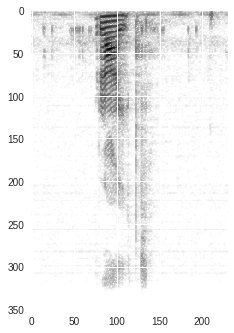

In [0]:
#The audio files we use for training are in saved in a certain direcory.
# Get files names:
files_names = [f for f in os.listdir('.') if os.path.isfile(f)]

  
#Creatning Training Data
Training_ims, classes = Create_Training_Data(files_names)

# The Testing Function is designed to Get a audio signals (voices) directly for the purposes of live testing...
# ... Hence, we need to feed it extracted audio:
# Get audio from files:
voices = [librosa.core.load(name, sr=48000)[0] for name in files_names]
Testing_ims = Create_Test_Data(voices)



#Example of the spectrogram images.
plt.imshow(Training_ims[0,:,:,0])

#Model & Training


In [0]:
model = Sequential()
model.add(BatchNormalization(input_shape= ims[0].shape))
model.add(Conv2D(5, kernel_size=(3, 3),activation='relu'))#,input_shape=(vos.shape)))#(ims[0].shape[0],ims[0].shape[1],1)))
model.add(Conv2D(10, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(9, 9)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])


x_train, x_test, y_train, y_test = train_test_split(Training_ims, classes, test_size=.2, random_state=957)

model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))


Train on 48 samples, validate on 13 samples
Epoch 1/100
48/48 [==============================] - 8s 156ms/step - loss: 1.2831 - acc: 0.4583 - val_loss: 3.3258 - val_acc: 0.3077
Epoch 2/100
48/48 [==============================] - 5s 99ms/step - loss: 3.8797 - acc: 0.3333 - val_loss: 1.2655 - val_acc: 0.2308
Epoch 3/100
48/48 [==============================] - 5s 96ms/step - loss: 2.2248 - acc: 0.3125 - val_loss: 1.8972 - val_acc: 0.3846
Epoch 4/100
48/48 [==============================] - 5s 96ms/step - loss: 1.4983 - acc: 0.5000 - val_loss: 1.3172 - val_acc: 0.3077
Epoch 5/100
48/48 [==============================] - 5s 97ms/step - loss: 1.3738 - acc: 0.4375 - val_loss: 1.6547 - val_acc: 0.3077
Epoch 6/100
48/48 [==============================] - 5s 98ms/step - loss: 1.1607 - acc: 0.5417 - val_loss: 1.2436 - val_acc: 0.3077
Epoch 7/100
48/48 [==============================] - 5s 98ms/step - loss: 1.2652 - acc: 0.5208 - val_loss: 1.1518 - val_acc: 0.3846
Epoch 8/100
48/48 [============

In [0]:
model.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_15 (Batc (None, 350, 230, 1)       4         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 348, 228, 5)       50        
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 346, 226, 10)      460       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 38, 25, 10)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 38, 25, 10)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 9500)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               1216128   
__________

In [0]:
# model.save('VR_model_3classes_100_84.h5')

modx =  keras.models.load_model('VR_model_3classes_100_84.h5')
modx.predict(x_test)

####Other Models

In [0]:
model3 = Sequential()
model3.add(BatchNormalization(input_shape= ims[0].shape))
model3.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))#,input_shape=(vos.shape)))#(ims[0].shape[0],ims[0].shape[1],1)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(5, 5)))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(classes.shape[1], activation='softmax'))

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_19 (Batc (None, 350, 230, 1)       4         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 348, 228, 32)      320       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 346, 226, 64)      18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 69, 45, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 69, 45, 64)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 198720)            0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               25436288  
__________

In [0]:
x_train, x_test, y_train, y_test = train_test_split(ims, c1, test_size=.2, random_state=1257)

x_train2 = np.array([x_train[:,:,:,0][i].flatten() for i in range(len(x_train)) ])
x_test2 = np.array([x_test[:,:,:,0][i].flatten() for i in range(len(x_test)) ])
Model = XGBClassifier(n_jobs=2, max_depth=35, learning_rate= 0.498922, n_estimators= 600)
Model.fit(x_train2, y_train)
predictions = Model.predict(x_test2)

print get_accuracies(y_test, predictions, classes=[0,1])


62.5


In [0]:
x_train = ims
y_train = classes

model2 = Sequential()
model2.add(BatchNormalization(input_shape=x_train.shape[1:]))
model2.add(Conv2D(64, (5, 5), padding='same', activation='elu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model2.add(Dropout(0.25))

model2.add(BatchNormalization(input_shape=x_train.shape[1:]))
model2.add(Conv2D(128, (5, 5), padding='same', activation='elu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(BatchNormalization(input_shape=x_train.shape[1:]))
model2.add(Conv2D(256, (5, 5), padding='same', activation='elu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(256, activation='elu'))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='softmax'))
model2.summary()

# x_train, x_test, y_train, y_test = train_test_split(ims, classes, test_size=.2, random_state=0)

# model2.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

# model2.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_9 (Batch (None, 350, 230, 1)       4         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 350, 230, 64)      1664      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 175, 115, 64)      0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 175, 115, 64)      0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 175, 115, 64)      256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 175, 115, 128)     204928    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 87, 57, 128)       0         
__________